Utility plotting functions and node labels

In [1]:
import sys
sys.path.append('..')
from typing import Optional
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
from scipy import stats
from plotting.plot_circular_graph import plot_circular_graph
from plotting_styles import colors
import eval_reallabor_utils

import data_utils
sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS
from feature_names import CONSTRUCTS_ANY_NON_CONDITIONAL as CONSTRUCTS
CONSTRUCTS = [c.lower() for c in CONSTRUCTS]
from feature_names import FLIP_OBSERVATION
NEGATIVE_ITEMS = [i for i in range(len(LABELS)) if LABELS[i] in FLIP_OBSERVATION]

def plot_network_graph(networks: tc.Tensor, directed: bool=True, invert_negative: bool=False, hide_self_connections: bool=True,
                       alpha_level: float=0.01, fisher_transform: bool=False, edge_threshold: Optional[float]=None,
                       node_labels: Optional[list]=None, title: Optional[str]=None, ax: Optional[plt.Axes]=None):    

    if len(networks.shape)==3:
        if fisher_transform:
            networks = tc.arctanh(networks)
        sig_adj = stats.ttest_1samp(networks, 0, axis=0).pvalue   # Show only connections with a weight significantly different from 0
        if fisher_transform:
            networks = tc.tanh(networks)
        networks = tc.nanmean(networks, dim=0)
        if fisher_transform:
            networks = tc.tanh(networks)
    else:
        sig_adj = tc.zeros_like(networks)
    if hide_self_connections:
        for i in range(networks.shape[0]):
            networks[i,i] = 0
    if edge_threshold is not None:
        networks = networks * (networks.abs() > edge_threshold)
    max_abs = networks.abs().max()
    if invert_negative:
        networks[NEGATIVE_ITEMS, :] *= -1
        networks[:, NEGATIVE_ITEMS] *= -1
        if node_labels is not None:
            node_labels = [node_labels[i] + '*' if i in NEGATIVE_ITEMS else node_labels[i] for i in range(len(node_labels)) ]

    networks_pos = networks * (networks > 0) * (sig_adj < alpha_level)
    networks_neg = networks * (networks < 0) * (sig_adj < alpha_level)
    max_pos = networks_pos.abs().max()
    max_neg = networks_neg.abs().max()

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6.27, 6.27))
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    plot_circular_graph(networks_pos, directed=directed, labels=node_labels, ax=ax, max_edge_width=max_pos/max_abs * 3, labelpad=5,
                            edge_kwargs={'edge_color':'k'}, node_kwargs={'node_color':colors.item_color_codes(LABELS)})
    plot_circular_graph(-networks_neg, directed=directed, labels=node_labels, ax=ax, max_edge_width=max_neg/max_abs * 3, labelpad=5,
                            edge_kwargs={'edge_color':'red'}, node_kwargs={'node_color':colors.item_color_codes(LABELS)})
    ax.set(xlim=(-2,2), ylim=(-2,2))
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()
    return ax, sig_adj


def plot_out_degree_centrality(networks: tc.Tensor, significant_only: bool=True, alpha_level: float=0.05,
                               node_labels: Optional[list]=None, ax: Optional[plt.Axes]=None):

    if significant_only:
        sig_adj = stats.ttest_1samp(networks, 0, axis=0).pvalue
        networks = networks * (sig_adj < alpha_level)
    out_degree_centrality = eval_reallabor_utils.weighted_eigenvector_centrality(networks, mode='out', absolute=True)
    mean_centrality = tc.nanmean(out_degree_centrality, dim=0)
    sem_centrality = tc.nanmean((out_degree_centrality - mean_centrality)**2, dim=0) / np.sqrt(out_degree_centrality.shape[0])
    order = tc.argsort(mean_centrality, descending=True)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6.27, 2.5))
    ax.bar(range(len(mean_centrality)), mean_centrality[order], yerr=sem_centrality[order], color=colors.item_color_codes(np.array(LABELS)[order]))
    if node_labels is not None:
        node_labels = np.array(node_labels)
        ax.set_xticks(range(len(mean_centrality)), labels=node_labels[order], rotation=45, ha='right')
    return ax

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Cross-Correlations

In [2]:
import pandas as pd
import data_utils

lag = 1
MRT = [2, 3]
cross_correlations = []
for mrt in MRT:
    networks = {}
    for pid, df in data_utils.zip_participants_data(data_utils.dataset_path(mrt, 'processed_csv_no_con')):
        crosscorr = pd.concat([df[LABELS].iloc[:-lag], df[LABELS].iloc[lag:]], axis=1, keys=['before', 'after']).corr()
        crosscorr = crosscorr.loc['before', 'after'].fillna(0)
        networks[pid] = tc.tensor(crosscorr.to_numpy()).float()
    cross_correlations.append(networks)

PLRNN networks

In [3]:
import sys
sys.path.append('..')
import torch as tc
import eval_reallabor_utils
import data_utils
from bptt.plrnn import PLRNN

MRT = [2, 3]
plrnn_networks = []
for mrt in MRT:
    results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_every_day_x6')
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
    models = eval_reallabor_utils.ModelCatalogue(results_dir)
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    networks = {}
    for pid, df in data_utils.zip_participants_data(test_data_dir):
        participant_networks = []
        model_dirs = models.get_latest_model_dirs(pid, timestep=1000)
        if model_dirs is None:
            continue
        for model_dir in model_dirs:
            model = PLRNN()
            model.init_from_model_path(model_dir)
            x = tc.tensor(df[LABELS].to_numpy()).float()
            network = eval_reallabor_utils.get_network_matrix(model, x).nanmean(0)
            participant_networks.append(network)
        networks[pid] = tc.stack(participant_networks, dim=0)    
    plrnn_networks.append(networks)

KalmanFilter networks

In [4]:
import sys
sys.path.append('..')
import torch as tc
import eval_reallabor_utils
import data_utils
import utils
from comparison_models.simple_models.models import KalmanFilter

MRT = [2, 3]
kalman_networks = []

for mrt in MRT:
    results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_Kalman_every_day')
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
    models = eval_reallabor_utils.ModelCatalogue(results_dir)
    networks = {}
    for pid, df in data_utils.zip_participants_data(test_data_dir):
        participant_networks = []
        model_dirs = models.get_latest_model_dirs(pid, timestep=1000)
        if model_dirs is None:
            continue
        for model_dir in model_dirs:
            args = utils.load_args(model_dir)
            model = KalmanFilter(args)
            model.init_from_model_path(model_dir)
            network = eval_reallabor_utils.get_network_matrix(model)
            participant_networks.append(network)
        networks[pid] = tc.stack(participant_networks, dim=0)
    kalman_networks.append(networks)

Networks of VAR models

In [5]:
import sys
sys.path.append('..')
import eval_reallabor_utils
import data_utils
import utils
from comparison_models.simple_models.models import VAR1

MRT = [2, 3]
var_networks = []

for mrt in MRT:
    results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_SimpleModels_every_day')
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
    models = eval_reallabor_utils.ModelCatalogue(results_dir, latent_model='VAR1')
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    networks = {}
    for pid, df in data_utils.zip_participants_data(test_data_dir):
        model_dir = models.get_best_latest_model_dir(pid, timestep=1000)
        if model_dir is None:
            continue
        args = utils.load_args(model_dir)
        model = VAR1(args)
        model.init_from_model_path(model_dir)
        network = eval_reallabor_utils.get_network_matrix(model)
        networks[pid] = network
    var_networks.append(networks)

Comparing the VAR network and cross-correlation of the subjects with lowest Wasserstein distance

47
239


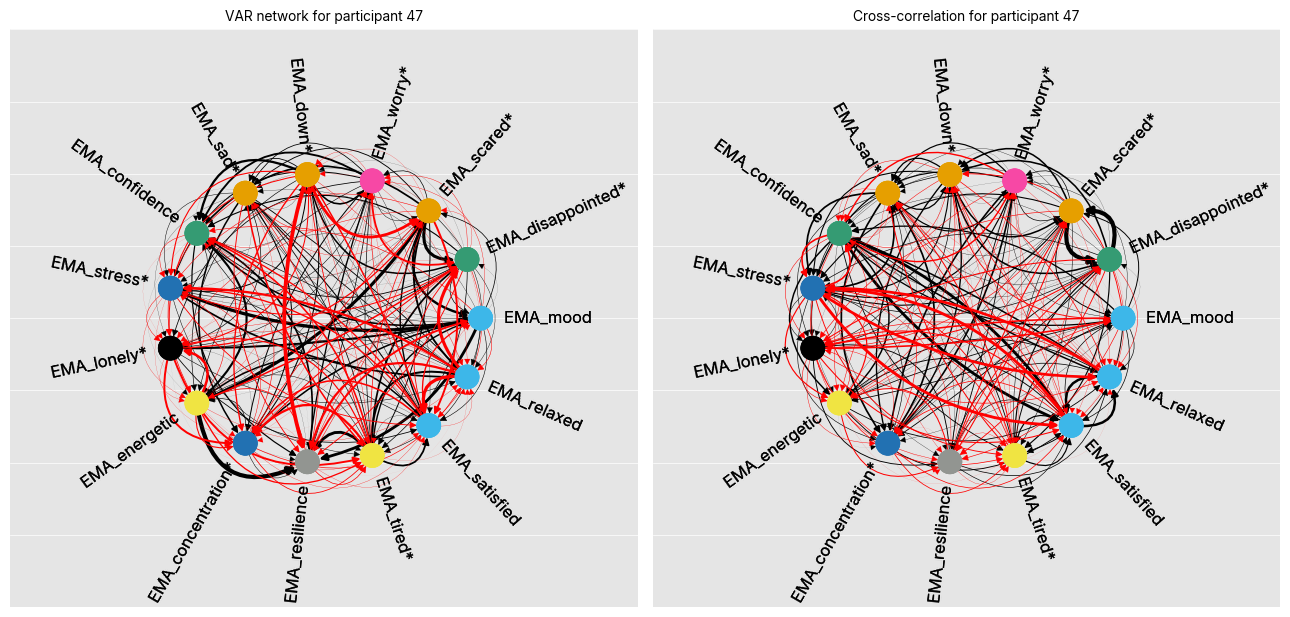

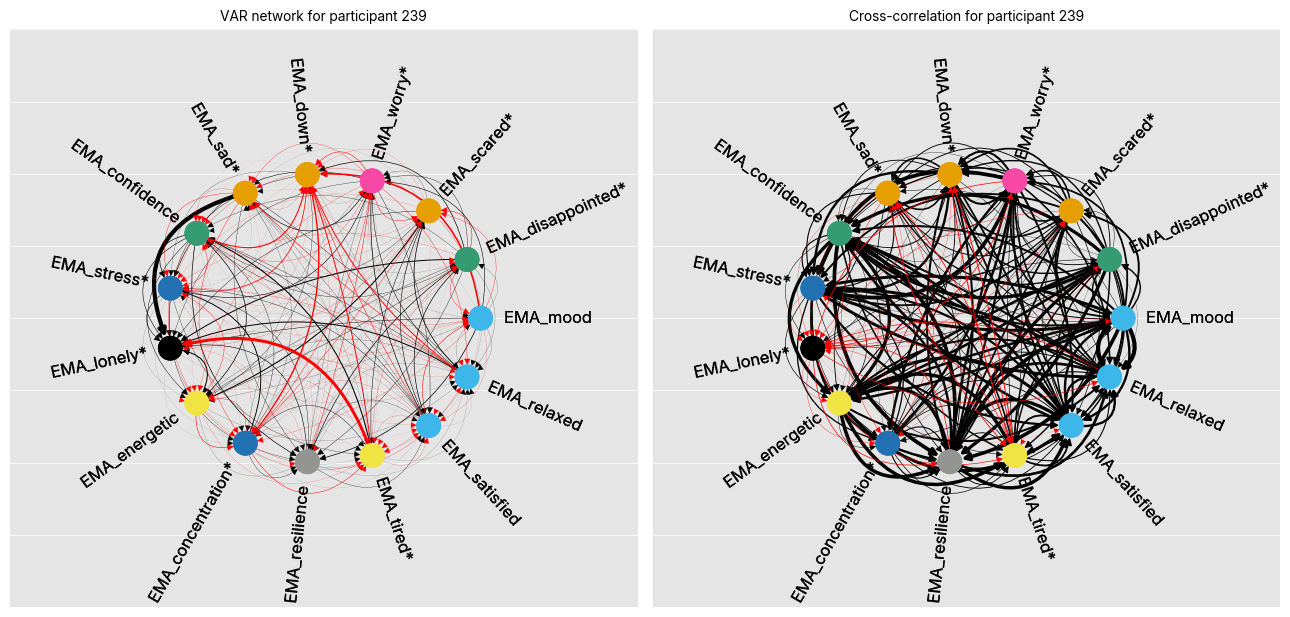

In [8]:
MRT = [2,3]
metric = 'wasserstein'
with PaperStyle():
    for m, mrt in enumerate(MRT):
        fig, axes = plt.subplots(1, 2, figsize=(13, 6.27))
        select_pid = var_cross_corr_distances[m][metric].dropna().sort_values().index[0]
        print(select_pid)
        plot_network_graph(var_networks[m][select_pid], node_labels=LABELS, title=f'VAR network for participant {select_pid}', ax=axes[0],
                           invert_negative=True)
        plot_network_graph(cross_correlations[m][select_pid], node_labels=LABELS, title=f'Cross-correlation for participant {select_pid}', ax=axes[1],
                           invert_negative=True)
    plt.show()

How big are the Wasserstein distances between the networks of different models?

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from plotting_styles import PaperStyle
import eval_reallabor_utils

MRT = [2,3]
with PaperStyle():

    for m, mrt in enumerate(MRT):

        pass



Exploratory: how similar are the wasserstein and spectrum metrics?

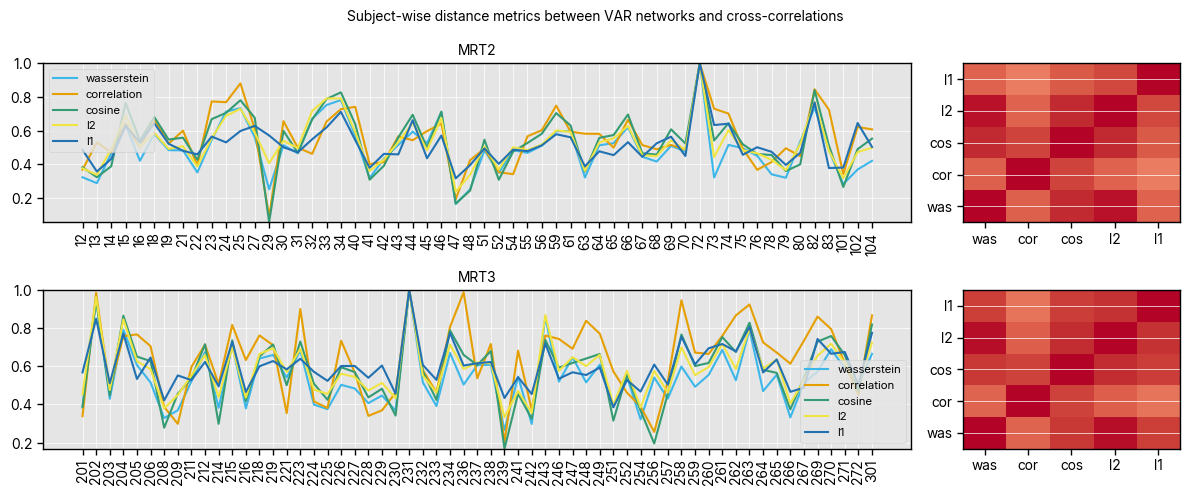

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from plotting_styles import PaperStyle
import eval_reallabor_utils

MRT = [2, 3]
var_cross_corr_distances = []
with PaperStyle():
    fig, axes = plt.subplots(2, 2, width_ratios=(4,1), figsize=(12, 5))
    fig.suptitle('Subject-wise distance metrics between VAR networks and cross-correlations')
    for m, mrt in enumerate(MRT):
        distances = pd.DataFrame(index=cross_correlations[m].keys(), columns=['wasserstein', 'correlation', 'cosine', 'l2', 'l1'], dtype='float64')
        for pid in cross_correlations[m]:
            if pid in var_networks[m].keys():
                distances.loc[pid, 'wasserstein'] = eval_reallabor_utils.network_wasserstein_distance(cross_correlations[m][pid], var_networks[m][pid])
                for mode in ['correlation', 'cosine', 'l2', 'l1']:
                    distances.loc[pid, mode] = eval_reallabor_utils.network_spectrum_distance(cross_correlations[m][pid], var_networks[m][pid], mode=mode).item()
        distances = distances / distances.max(axis=0)
        var_cross_corr_distances.append(distances)
        distances.reset_index(drop=True).plot(ax=axes[m, 0])
        axes[m, 0].set(xticks=range(len(distances.index)), title=f'MRT{mrt}')
        axes[m, 0].set_xticklabels(distances.index, rotation=90)
        dist_corr = distances.corr()
        axes[m, 1].imshow(dist_corr, cmap='coolwarm', vmin=-1, vmax=1)
        axes[m, 1].set(xticks=range(len(dist_corr.columns)), yticks=range(len(dist_corr.index)), xticklabels=dist_corr.columns.str[:3], yticklabels=dist_corr.index.str[:3])

    plt.tight_layout()
    plt.show()